# Fairness Checking: Statistical Parity Constraint Experiment
This notebook uses PuLP to solve the linear program outlined in the "Fairness Checking" document. Here, **we experiment with varying the upper bound constraint on w and see its effects on the objective value.**

In [86]:
!pip install pulp

In [87]:
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt
import collections

In [88]:
# Run this cell to mount your Google Drive.
# from google.colab import drive
# drive.mount('/content/drive')

## Import Predicted Data
We take A (the protected attribute) to be the 'race' variable, and a = 0 while a' = 1. The last column, 'prediction,' is our f(X) variable, which can either be 0 or 1.

In [89]:
pred_df = pd.read_csv('./../predicted_data/fair_logreg_COMPAS.csv')

In [90]:
pred_df.head(5)

,Unnamed: 0,sex,race,age_cat=25 to 45,age_cat=Greater than 45,age_cat=Less than 25,priors_count=0,priors_count=1 to 3,priors_count=More than 3,c_charge_degree=F,c_charge_degree=M,two_year_recid,predictions
0,7960,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,7762,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,6466,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,9759,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,7130,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0


In [91]:
# Our protected variable A is race, and a = 0 or a = 1. 
a = pred_df['race']
np.asarray(a)
a_0_indices = []
a_1_indices = []

for i in range(len(a)):
    if a[i] == 0:
        a_0_indices.append(i)
    elif a[i] == 1:
        a_1_indices.append(i)

In [92]:
# Our pi variables are simply the proportions of a_0 or a_1 
pi_0 = float(len(a_0_indices))/(len(a_0_indices) + len(a_1_indices))
pi_1 = float(len(a_1_indices))/(len(a_0_indices) + len(a_1_indices))

In [93]:
print(pi_0)
print(pi_1)

0.5972222222222222
0.4027777777777778


In [94]:
# Our prediction probability is under 'prediction_probs.' Notice that we use the 
# actual probability of the label, not the label itself.
f_X = pred_df['predictions']
np.asarray(f_X)

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0.,
       1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 1.

In [95]:
# Check if the dimensions match
print(len(f_X))
print(len(a_0_indices) + (len(a_1_indices)))

792
792


## Create Linear Program
We use the PuLP package to create our linear program.

Here, we allow another input for the upper bound on all w's. This must be a number between 0 and 1.

In [96]:
# Input: function f(X), constraint
# Output: (solved) model, weights
def SP_linear_prog(f_X, lower_bound, upper_bound):
  # Check if constraint is between 0 and 1
  assert(0 < lower_bound < 1)
  assert(0 < upper_bound < 1)

  # Define the linear program as a maximization problem
  model = pulp.LpProblem("Statistical Parity Fairness Checking", pulp.LpMaximize)
  
  # Our w variable in the objective
  # Lower bound constraint set here with lowBound=0 option
  w = pulp.LpVariable.dicts("w", (i for i in range(len(f_X))),lowBound=0, cat='Continuous')
  
  # Objective Function
  model += pulp.lpSum(
      [(1./pi_0) * w[index] * f_X[index] for index in a_0_indices] +
      [- (1./pi_1) * w[index] * f_X[index] for index in a_1_indices])
  
  # Constraint that the \sum(w_i * 1{a = 0}) = pi_0
  model += pulp.lpSum([w[index] for index in a_0_indices]) == pi_0
  
  # Constraint that the \sum(w_i * 1{a = 1}) = pi_1
  model += pulp.lpSum([w[index] for index in a_1_indices]) == pi_1
  
  # Constraint that the w's all sum to 1
  model += pulp.lpSum([w[i] for i in range(len(f_X))]) == 1

  # IMPORTANT: Constraint for the w's (experiment with this)
  for weight in w:
    model += w[weight] <= upper_bound
    model += w[weight] >= lower_bound

  # Solve the linear program
  model.solve()
  pulp.LpStatus[model.status]
  
  # Returns the model and the weights
  return model, w

# Get the results
def weights_dictionary(w):
  results_dict = dict()
  for i in range(len(f_X)):
    results_dict[i] = w[i].varValue
  return results_dict

## Experiment with Constraints
Experiment with setting the constraints as: $$w_i \leq \frac{(1 + \epsilon)}{n}$$ and $$\frac{(1 - \epsilon)}{n} \leq w_i$$ where n is the number of samples in the data.

In [97]:
epsilon_granule = 0.01

lower_bounds = []
upper_bounds = []
objective_values = []
dist_weights = []
epsilons = []

# Iterate over constraints
for i in range(1, 100):
  epsilon = epsilon_granule * i
  lower_bound = (1 - epsilon)/(len(f_X))
  upper_bound = (1 + epsilon)/(len(f_X))
  model, weights = SP_linear_prog(f_X, lower_bound, upper_bound)
  objective_values.append(pulp.value(model.objective))
  epsilons.append(epsilon)
  lower_bounds.append(lower_bound)
  upper_bounds.append(upper_bound)
  dist_weights.append(weights)

Text(0.5, 1.0, 'Constraint on w vs. SP LP Objective Value')

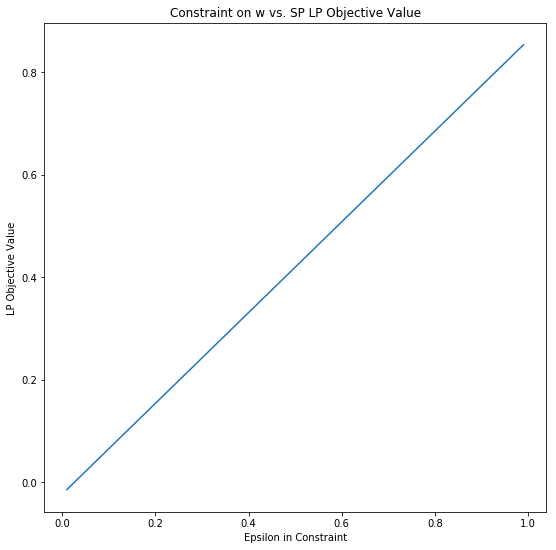

In [98]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(epsilons, objective_values)
plt.xlabel('Epsilon in Constraint')
plt.ylabel('LP Objective Value')
plt.title('Constraint on w vs. SP LP Objective Value')

In [99]:
print(len(dist_weights))
print(len(epsilons))

epsilon_to_weights = dict()
for i in range(len(epsilons)):
    epsilon_to_weights[epsilons[i]] = weights_dictionary(dist_weights[i])

99
99


<BarContainer object of 792 artists>

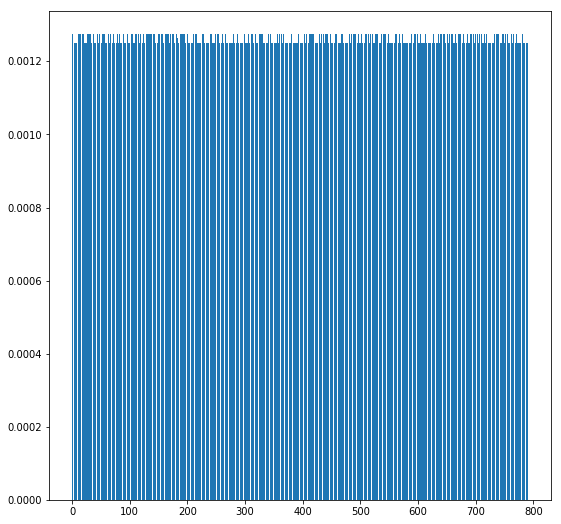

In [100]:
# Plot the distribution of weights
plt.figure(figsize=(9,9))
plt.bar(epsilon_to_weights[0.01].keys(), epsilon_to_weights[0.01].values())

In [101]:
print(len(pred_df))
print(len(epsilon_to_weights[0.01]))

792
792


## Marginal Distributions

In [102]:
pred_df['weights'] = epsilon_to_weights[0.2].values() # For example, when epsilon = 0.05
pred_df.head(5)

,Unnamed: 0,sex,race,age_cat=25 to 45,age_cat=Greater than 45,age_cat=Less than 25,priors_count=0,priors_count=1 to 3,priors_count=More than 3,c_charge_degree=F,c_charge_degree=M,two_year_recid,predictions,weights
0,7960,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.001515
1,7762,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.001515
2,6466,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.001515
3,9759,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.001515
4,7130,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.001010


In [103]:
# Marginal Distribution Function
def marginalize(data, X_attr, weights):
    X_values = data[X_attr]
    key_list = np.unique(X_values)
    X_marginal = {k: 0 for k in key_list}
    for i in range(0, len(X_values)):
        X_marginal[X_values[i]] = X_marginal[X_values[i]] + weights[i]
    return X_marginal

def freq_dict(data, X_attr):
    X_values = data[X_attr].value_counts()
    X_freqs = dict()
    for value in X_values.keys():
        X_freqs[value] = float(X_values[value])/float(len(data))
    return X_freqs

# Returns a tuple of two lists of the items in each dictionary sorted by order of their keys
def graph_tuple(dict1, dict2):
    tuple1 = []
    tuple2 = []
    for key in sorted(dict1.keys()):
        tuple1.append(dict1[key])
        tuple2.append(dict2[key])
    
    return (tuple1, tuple2)

In [104]:
# Get the unweighted and weighted distributions on the data
X_sex_freq = freq_dict(pred_df, 'sex')
X_sex_marginal = marginalize(pred_df, 'sex', pred_df['weights'])

print(X_sex_freq)
print(X_sex_marginal)

X_sex_tuple = graph_tuple(X_sex_freq, X_sex_marginal)

{0.0: 0.821969696969697, 1.0: 0.17803030303030304}
{0.0: 0.8209595877999992, 1.0: 0.17904040230000062}


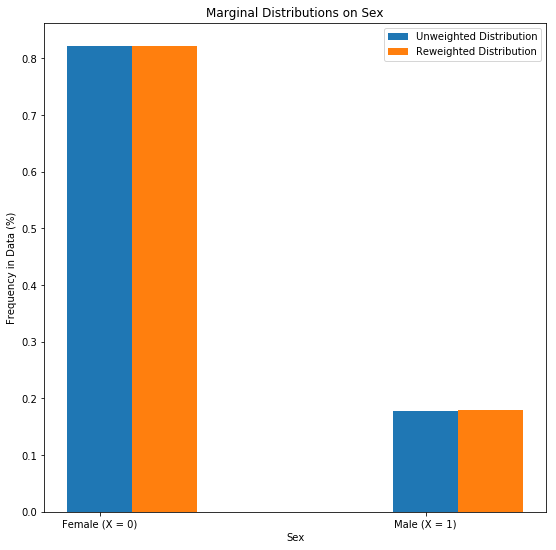

In [105]:
# Marginal Distribution on Sex 

X = np.arange(len(X_sex_freq))
plt.figure(figsize=(9,9))
plt.title('Marginal Distributions on Sex')
plt.bar(X, X_sex_tuple[0], width=0.2, align='center')
plt.bar(X+0.2, X_sex_tuple[1], width=0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Female (X = 0)', 'Male (X = 1)'])
plt.xlabel('Sex')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [106]:
X_age_25_45_freq = freq_dict(pred_df, 'age_cat=25 to 45')
X_age_25_45_marginal = marginalize(pred_df, 'age_cat=25 to 45', pred_df['weights'])
X_age_25_45_tuple = graph_tuple(X_age_25_45_freq, X_age_25_45_marginal)

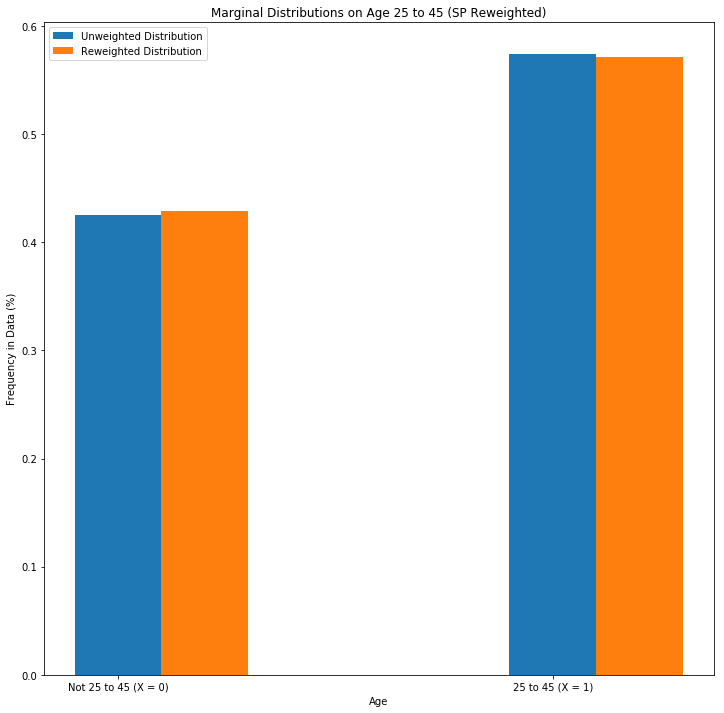

In [107]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_25_45_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age 25 to 45 (SP Reweighted)')
plt.bar(X, X_age_25_45_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_25_45_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Not 25 to 45 (X = 0)', '25 to 45 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [108]:
X_age_25_freq = freq_dict(pred_df, 'age_cat=Less than 25')
X_age_25_marginal = marginalize(pred_df, 'age_cat=Less than 25', pred_df['weights'])
X_age_25_tuple = graph_tuple(X_age_25_freq, X_age_25_marginal)

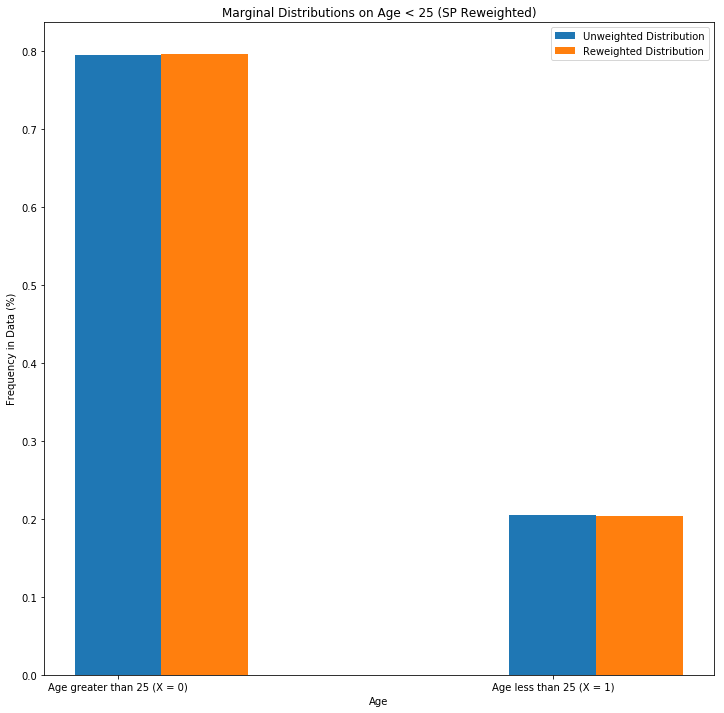

In [109]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_25_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age < 25 (SP Reweighted)')
plt.bar(X, X_age_25_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_25_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Age greater than 25 (X = 0)', 'Age less than 25 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [110]:
X_age_45_freq = freq_dict(pred_df, 'age_cat=Greater than 45')
X_age_45_marginal = marginalize(pred_df, 'age_cat=Greater than 45', pred_df['weights'])
X_age_45_tuple = graph_tuple(X_age_45_freq, X_age_45_marginal)

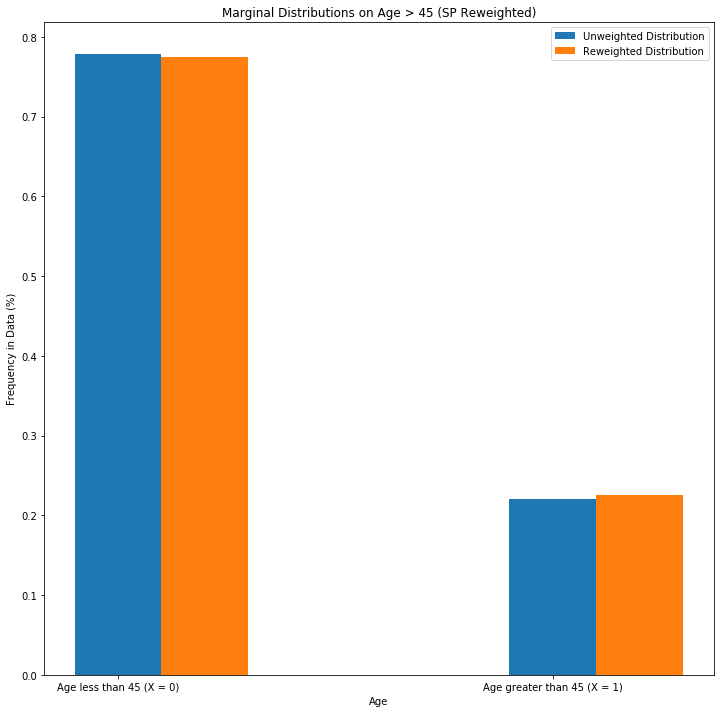

In [111]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_45_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age > 45 (SP Reweighted)')
plt.bar(X, X_age_45_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_45_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Age less than 45 (X = 0)', 'Age greater than 45 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [112]:
X_priors_freq = freq_dict(pred_df, 'priors_count=0')
X_priors_marginal = marginalize(pred_df, 'priors_count=0', pred_df['weights'])
X_priors_tuple = graph_tuple(X_priors_freq, X_priors_marginal)

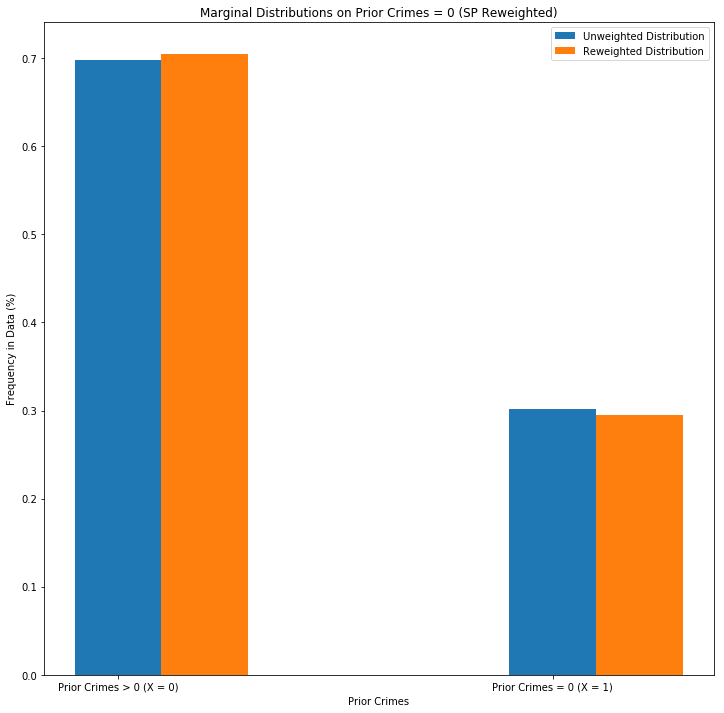

In [113]:
# Marginal Distribution on Age 
X = np.asarray(list(X_priors_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Prior Crimes = 0 (SP Reweighted)')
plt.bar(X, X_priors_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_priors_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Prior Crimes > 0 (X = 0)', 'Prior Crimes = 0 (X = 1)'])
plt.xlabel('Prior Crimes')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [114]:
X_priors_freq = freq_dict(pred_df, 'priors_count=1 to 3')
X_priors_marginal = marginalize(pred_df, 'priors_count=1 to 3', pred_df['weights'])
X_priors_tuple = graph_tuple(X_priors_freq, X_priors_marginal)

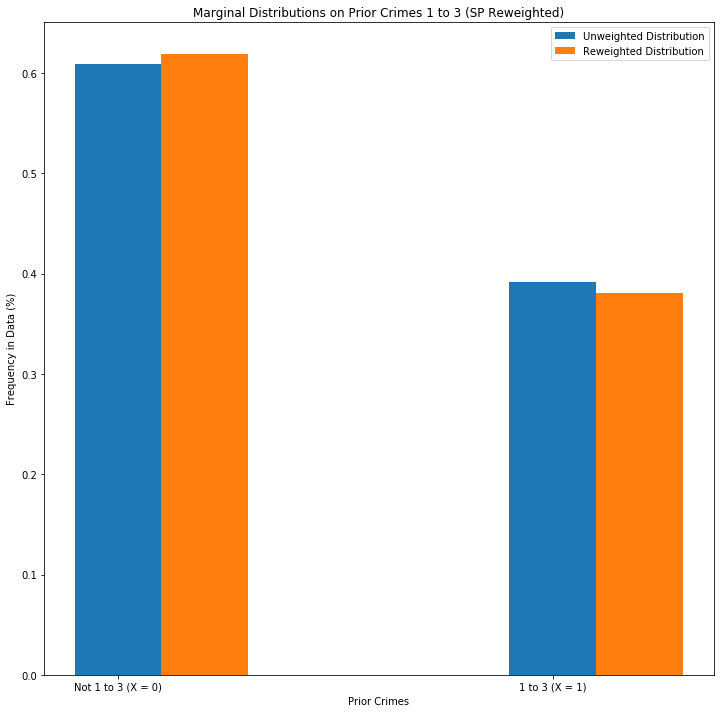

In [115]:
# Marginal Distribution on Age 
X = np.asarray(list(X_priors_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Prior Crimes 1 to 3 (SP Reweighted)')
plt.bar(X, X_priors_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_priors_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Not 1 to 3 (X = 0)', '1 to 3 (X = 1)'])
plt.xlabel('Prior Crimes')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [116]:
X_priors_freq = freq_dict(pred_df, 'priors_count=More than 3')
X_priors_marginal = marginalize(pred_df, 'priors_count=More than 3', pred_df['weights'])
X_priors_tuple = graph_tuple(X_priors_freq, X_priors_marginal)

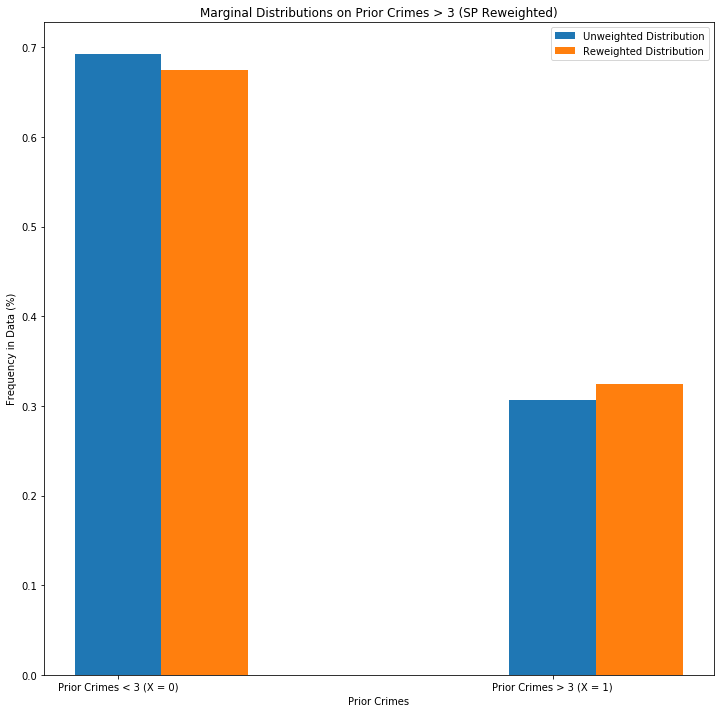

In [117]:
# Marginal Distribution on Age 
X = np.asarray(list(X_priors_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Prior Crimes > 3 (SP Reweighted)')
plt.bar(X, X_priors_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_priors_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Prior Crimes < 3 (X = 0)', 'Prior Crimes > 3 (X = 1)'])
plt.xlabel('Prior Crimes')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [118]:
X_charge_deg_freq = freq_dict(pred_df, 'c_charge_degree=F')
X_charge_deg_marginal = marginalize(pred_df, 'c_charge_degree=F', pred_df['weights'])
X_charge_deg_tuple = graph_tuple(X_charge_deg_freq, X_charge_deg_marginal)

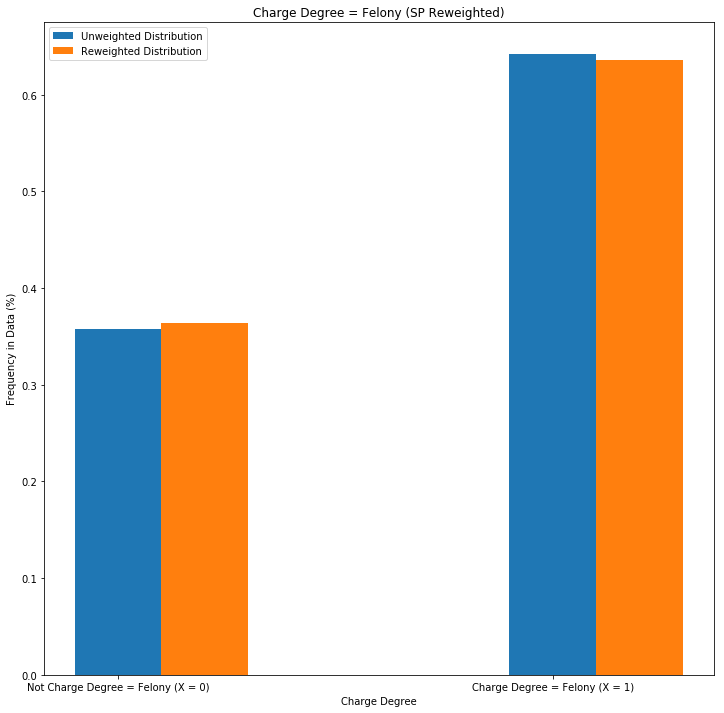

In [119]:
# Marginal Distribution on Age 
X = np.asarray(list(X_priors_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Charge Degree = Felony (SP Reweighted)')
plt.bar(X, X_charge_deg_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_charge_deg_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Not Charge Degree = Felony (X = 0)', 'Charge Degree = Felony (X = 1)'])
plt.xlabel('Charge Degree')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [120]:
X_charge_deg_freq = freq_dict(pred_df, 'c_charge_degree=M')
X_charge_deg_marginal = marginalize(pred_df, 'c_charge_degree=M', pred_df['weights'])
X_charge_deg_tuple = graph_tuple(X_charge_deg_freq, X_charge_deg_marginal)

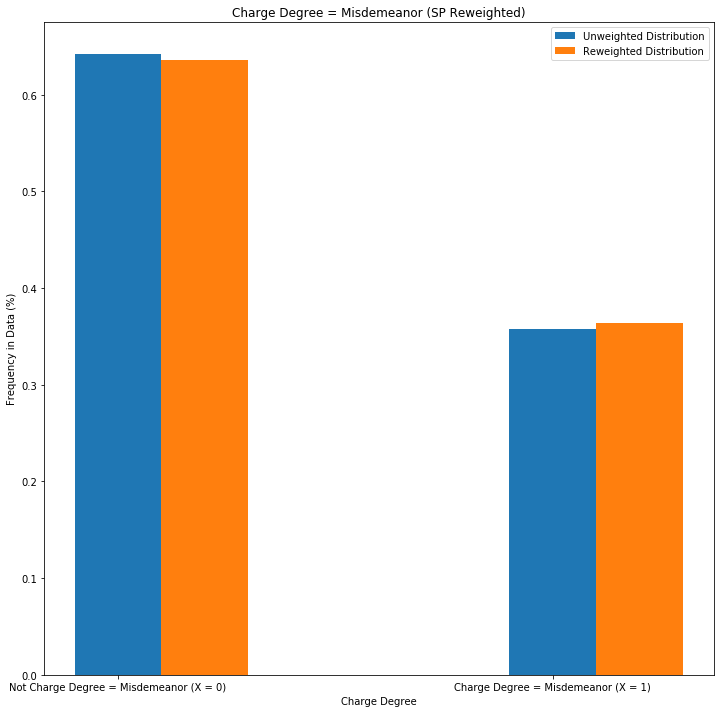

In [121]:
# Marginal Distribution on Age 
X = np.asarray(list(X_priors_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Charge Degree = Misdemeanor (SP Reweighted)')
plt.bar(X, X_charge_deg_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_charge_deg_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Not Charge Degree = Misdemeanor (X = 0)', 'Charge Degree = Misdemeanor (X = 1)'])
plt.xlabel('Charge Degree')
plt.ylabel('Frequency in Data (%)')
plt.show()